<a href="https://colab.research.google.com/github/HJBJalaly/DLeeg/blob/master/best%20channel/Mine/Search_1Ch_Base_Normal_FitGenerate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install mne

In [0]:
'''
Rivision:
980726:
  Differenet in/out shift Sampling
980727:
  The model is revised to addapt with fit_generate
980803:
  All Generators are merged.
  
  
  

'''

In [0]:
# Parameters:

EpochNum=25
subject_number=109
RemoveBaseLine=0
task_index = [1] # task: REO
Best1Channel=[]
TryStr='Try1'


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64

Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [0]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random

# For clear memory
import gc

#
import copy 
import csv
import pandas as pd
import datetime
import time
import os


# To download file from google drive
from google.colab import files

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend

# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

In [0]:
# load dataset in array

task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database',update_path=False)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)



In [0]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)



train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA
                  

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # Orthogonal Channel
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]

    
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,len(SubjectArrayShuffled))
                yield TrainImage, TrainLabelClass 

                

#################################################################################################
Index: 0  > Channel: Fp1
  Already Done.
#################################################################################################
Index: 1  > Channel: Fp2
  Already Done.
#################################################################################################
Index: 2  > Channel: F7
  Already Done.
#################################################################################################
Index: 3  > Channel: F3
  Already Done.
#################################################################################################
Index: 4  > Channel: Fz
  Already Done.
#################################################################################################
Index: 5  > Channel: F4
  Already Done.
#################################################################################################
Index: 6  > Channel: F8
  Already Done.
################################

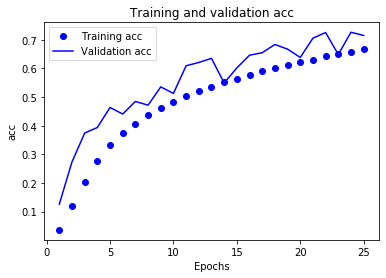


#################################################################################################
Index: 10  > Channel: C4
Epoch 1/25
997/997 [==============================] - 34s 35ms/step - loss: 4.3595 - acc: 0.0403 - val_loss: 3.6069 - val_acc: 0.1458
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.4813 - acc: 0.1227 - val_loss: 2.8396 - val_acc: 0.3142
Epoch 3/25
997/997 [==============================] - 33s 34ms/step - loss: 2.9011 - acc: 0.2156 - val_loss: 2.4551 - val_acc: 0.3468
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 2.5108 - acc: 0.2937 - val_loss: 2.1639 - val_acc: 0.3991
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 2.2643 - acc: 0.3501 - val_loss: 1.8607 - val_acc: 0.4901
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 2.0739 - acc: 0.3980 - val_loss: 1.7974 - val_acc: 0.4859
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - lo

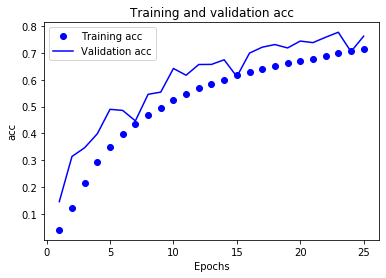

#################################################################################################
Index: 11  > Channel: T8
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.2251 - acc: 0.0412 - val_loss: 3.4370 - val_acc: 0.1403
Epoch 2/25
997/997 [==============================] - 32s 33ms/step - loss: 3.3050 - acc: 0.1289 - val_loss: 2.6579 - val_acc: 0.3498
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.7024 - acc: 0.2335 - val_loss: 2.1062 - val_acc: 0.4563
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 2.2951 - acc: 0.3216 - val_loss: 1.7577 - val_acc: 0.5299
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 2.0440 - acc: 0.3806 - val_loss: 1.9154 - val_acc: 0.4223
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.8704 - acc: 0.4238 - val_loss: 1.5649 - val_acc: 0.5259
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

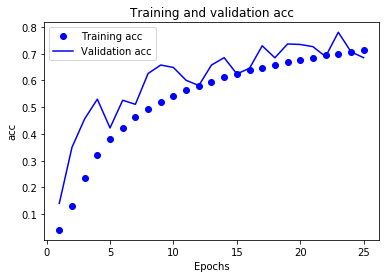

#################################################################################################
Index: 12  > Channel: P7
Epoch 1/25
997/997 [==============================] - 35s 35ms/step - loss: 4.3034 - acc: 0.0376 - val_loss: 3.5103 - val_acc: 0.1380
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.3853 - acc: 0.1205 - val_loss: 2.8205 - val_acc: 0.2750
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.8636 - acc: 0.2076 - val_loss: 2.3772 - val_acc: 0.3674
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 2.5189 - acc: 0.2771 - val_loss: 2.0834 - val_acc: 0.4362
Epoch 5/25
997/997 [==============================] - 37s 37ms/step - loss: 2.2617 - acc: 0.3362 - val_loss: 2.0460 - val_acc: 0.4101
Epoch 6/25
187/997 [====>.........................] - ETA: 22s - loss: 2.1378 - acc: 0.3661

In [0]:
#####################################################################################################
# seacrh all channels


# Read Previous intruppted execution, if any, or create new empty cell
ResultFileName='SearchSpaceResultTable_1Ch_S'+str(subject_number)
if RemoveBaseLine==0:
  ResultFileName=ResultFileName+"_RemoveBaseLineOff"
else:
  ResultFileName=ResultFileName+"_RemoveBaseLineOn"

ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+'.csv'

  
if os.path.isfile('/content/drive/My Drive/Deep Results/'+ResultFileName):
#   print("here")
  SearchSpaceResult=pd.read_csv('/content/drive/My Drive/Deep Results/'+ResultFileName, header=None)
#   print(Test)
  SearchSpaceResult=SearchSpaceResult.values
#   print(Test)
  
else:
    SearchSpaceResult=np.zeros((len(Search_Space_Channel),6),dtype = float)



#####################################################################################################
# seacrh all channels

for IndexCh in range(len(Search_Space_Channel)):
    
    #################################################################################################
    # Print Iteration
    print("#################################################################################################")
    print("Index:", IndexCh," > Channel:", Search_Space_Channel_Name[IndexCh])
    
    if(SearchSpaceResult[IndexCh][0]>0):
      print("  Already Done.")
      continue 
    
    
    #################################################################################################
    # Reset Model and Data Arrays
    list_channel=Best1Channel + [Search_Space_Channel[IndexCh]]
    ch_number=len(list_channel)
    
    list_rawdataTemp=list_rawdata.copy()

    #################################################################################################
    # Construct Data Generator

    GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                     ListRawDataMain=list_rawdataTemp.copy(),
                                     SubjectArrayShuffled=subject_number_array_shuffled,
                                     ListChannel=list_channel,
                                     RemoveBaseLineFlag=RemoveBaseLine,
                                     WindowLen=window_len,
                                     OuterSampleShift=outer_sample_shift,
                                     InnerSampleShift=inner_sample_shift,
                                     SampelNumberPerSec=sampel_number_per_sec,
                                     ImageArrayShuffled=train_shuff)

    GenValidationData=GenerateGeneralData(BatchSize=batch_size,
                                     ListRawDataMain=list_rawdataTemp.copy(),
                                     SubjectArrayShuffled=subject_number_array_shuffled,
                                     ListChannel=list_channel,
                                     RemoveBaseLineFlag=RemoveBaseLine,
                                     WindowLen=window_len,
                                     OuterSampleShift=outer_sample_shift,
                                     InnerSampleShift=inner_sample_shift,
                                     SampelNumberPerSec=sampel_number_per_sec,
                                     ImageArrayShuffled=val_shuff)

    GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                     ListRawDataMain=list_rawdataTemp.copy(),
                                     SubjectArrayShuffled=subject_number_array_shuffled,
                                     ListChannel=list_channel,
                                     RemoveBaseLineFlag=RemoveBaseLine,
                                     WindowLen=window_len,
                                     OuterSampleShift=outer_sample_shift,
                                     InnerSampleShift=inner_sample_shift,
                                     SampelNumberPerSec=sampel_number_per_sec,
                                     ImageArrayShuffled=test_shuff)

    #################################################################################################
    # Create Model
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(subject_number, activation = 'softmax'))
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer= optimizers.RMSprop(lr= 1e-4),
                  metrics = ['acc'])
    
    #################################################################################################
    # Train the Model
    history = model.fit_generator(epochs =EpochNum,
                                  generator=GenTrainData,
                                  steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                                  validation_data=GenValidationData,
                                  validation_steps =np.ceil(val_number*subject_number/batch_size),
                                  use_multiprocessing=False,
                                  workers=1)

    #################################################################################################
    # Evalute the Model
    TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
    ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
    TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
    print('     TrainResult ([loss , acc])=',TrainResult)
    print('ValidationResult ([loss , acc])=',ValidationResult)
    print('      TestResult ([loss , acc])=',TestResult)
    
    #################################################################################################
    # Extract Result
    #SearchSpaceResult[IndexCh][0]=history.history['loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][1]=history.history['acc'][EpochNum-1]
    #SearchSpaceResult[IndexCh][2]=history.history['val_loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][3]=history.history['val_acc'][EpochNum-1]
    
    SearchSpaceResult[IndexCh][0]=TrainResult[0]
    SearchSpaceResult[IndexCh][1]=TrainResult[1]
    SearchSpaceResult[IndexCh][2]=ValidationResult[0]
    SearchSpaceResult[IndexCh][3]=ValidationResult[1]
    SearchSpaceResult[IndexCh][4]=TestResult[0]
    SearchSpaceResult[IndexCh][5]=TestResult[1]
    
    #################################################################################################
    # Save current Result to google drive

    with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerows(SearchSpaceResult)


    #################################################################################################
    # plot accuracy
    history_dict = history.history 
    acc_values = history_dict ['acc'] 
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)


    #plt.clf()
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title('Training and validation acc for '+ Search_Space_Channel_Name[IndexCh]) 
    plt.xlabel('Epochs') 
    plt.ylabel('acc') 
    plt.legend()
    plt.show()

    #################################################################################################
    # Erase Memory
    KerasBackend.clear_session()
    
    del model
    del history
    del TrainResult
    del ValidationResult
    del TestResult
    del GenTrainData
    del GenValidationData
    del GenTestData
    
    KerasBackend.clear_session()
    
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    
#################################################################################################    
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_1Ch_S'+str(subject_number)
ChannelFileName='ChannelNames_1Ch_S'+str(subject_number)
ImageFileName='SearchSpaceResult_1Ch_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'


ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)



# Save To Google Drive
ImageEEG.savefig('/content/drive/My Drive/Deep Results/'+ImageFileName)


with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open('/content/drive/My Drive/Deep Results/'+ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)
    
    
#################################################################################################
# Delete Temp. Result Table File

    

In [0]:
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_1Ch_S'+str(subject_number)
ChannelFileName='ChannelNames_1Ch_S'+str(subject_number)
ImageFileName='SearchSpaceResult_1Ch_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'


ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.pdf'



# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)


# Save
ImageEEG.savefig(ImageFileName)

with open(ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open(ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)
    
# Downlaod
import os
while os.path.isfile(ResultFileName)==False:
  print('wait')
  time.sleep(1)

files.download(ResultFileName)
files.download(ChannelFileName)
files.download(ImageFileName)